# Testing Validation of skull stripping with deepbrain and FSL (S3)


In [ ]:
import os
import sys
import time
from pathlib import Path
module_path = os.path.abspath('../utils')
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib 
from deepbrain import Extractor
import ants

from skull_stripping_ants.s3 import *
from deepbrain_skull_strip import deep_brain_skull_stripping
from base_mri import list_available_images, delete_useless_images, set_env_variables, load_mri, save_mri, create_file_name_from_path
from antspy_registration import register_image_with_atlas
from crop_mri import crop_mri_at_center
from standardize_mri import clip_and_normalize_mri

%load_ext autoreload
%autoreload 2

In [2]:
def show_slices(img):
    img_size = moving.shape
    img.plot(axis =0,figsize=2,nslices=6,title=f'Image size: {img_size}')
    img.plot(axis =1,figsize=2,nslices=6,title=f'Image size: {img_size}')
    img.plot(axis =2,figsize=2,nslices=6,title=f'Image size: {img_size}')

def plot_intensity(image,title = 'Voxel Intensity Visualization',cumulative=False,log_scale = True):

    if type(image) is np.ndarray:
        img_flatten = image.ravel()
    else:
        img_flatten = image.numpy().ravel()
    if cumulative:
        sns.histplot(img_flatten,bins=100,cumulative=True,stat='density',log_scale=[False, log_scale])
    else:
        sns.histplot(img_flatten,bins=100,log_scale=[False, log_scale])
    plt.title(title)
    plt.xlabel('Voxel intensity')
    plt.show()

def get_mean_and_std(img,lower_bound=0.02,upper_bound = 99.8):
    lower_perc,upper_perc = get_percentiles(img,lower_bound=lower_bound,upper_bound=upper_bound)
    img_flatten = img.numpy().ravel()
    
    img_flatten[img_flatten > upper_perc] = upper_perc
    img_flatten[img_flatten < lower_perc] = lower_perc

    return img_flatten.mean(),img_flatten.std()

def get_percentiles(img,lower_bound=0.02,upper_bound = 99.8):
    img_flatten = img.numpy().ravel()
    lower_perc = np.percentile(img_flatten,q=lower_bound)
    upper_perc = np.percentile(img_flatten,q=upper_bound)
    return lower_perc,upper_perc

def scale_image_linearly(img_array:np.ndarray,lower_bound,upper_bound):
    img_array = (img_array - lower_bound) / (upper_bound - lower_bound)
    return img_array

def clip_image_intensity(image:np.ndarray,lower_threshold,upper_threshold):
    image[image > upper_threshold] = upper_threshold
    image[image < lower_threshold] = lower_threshold
    return image

def get_atlas_thresholds(atlas_path = None,lower_bound=0.02,upper_bound=99.8):
    
    if atlas_path is None: return (0.05545412003993988, 92.05744171142578) #for 0.02 and 99.8

    fixed = ants.image_read(atlas_path)
    return get_percentiles(fixed,lower_bound=lower_bound, upper_bound = upper_bound)

def apply_clipping_and_normalization(image, lower_bound = 0.02, upper_bound = 99.8):

    lower_threshold,upper_threshold = get_percentiles(image,lower_bound=lower_bound, upper_bound = upper_bound)
    image_clipped = clip_image_intensity(image.numpy(),lower_threshold=lower_threshold, upper_threshold=upper_threshold)
    lower_atlas_threshold, upper_atlas_threshold = get_atlas_thresholds()
    image_scaled = scale_image_linearly(image_clipped,lower_atlas_threshold,upper_atlas_threshold)
    return image_scaled

def crop_image(image,bbox_size = 100,center_dim = None):
    if center_dim is None:
        center_dim = [int(np.ceil(x/2)) for x in image.shape]
    lower_dim = [int(x - bbox_size/2) for x in center_dim]
    upper_dim = [int(x + bbox_size/2) for x in center_dim]

    cropped_img =  ants.crop_indices(image,lowerind = lower_dim,upperind = upper_dim)
    return cropped_img

In [3]:
input_path = "/home/lucasthim1/alzheimer_data/NFBS_Dataset/A00028185/sub-A00028185_ses-NFB3_T1w.nii.gz"
input_mask_path = "/home/lucasthim1/alzheimer_data/NFBS_Dataset/A00028185/sub-A00028185_ses-NFB3_T1w_brainmask.nii.gz"
input_brain_path = "/home/lucasthim1/alzheimer_data/NFBS_Dataset/A00028185/sub-A00028185_ses-NFB3_T1w_brain.nii.gz"
output_path = "/home/lucasthim1/alzheimer_data/test/"
atlas_path = '/home/lucasthim1/alzheimer_data/Atlas/atlas_t1.nii'

In [4]:
os.listdir("/home/lucasthim1/alzheimer_data/NFBS_Dataset/A00028185/")

['sub-A00028185_ses-NFB3_T1w.nii.gz',
 'sub-A00028185_ses-NFB3_T1w_brain.nii.gz',
 'sub-A00028185_ses-NFB3_T1w_brainmask.nii.gz']

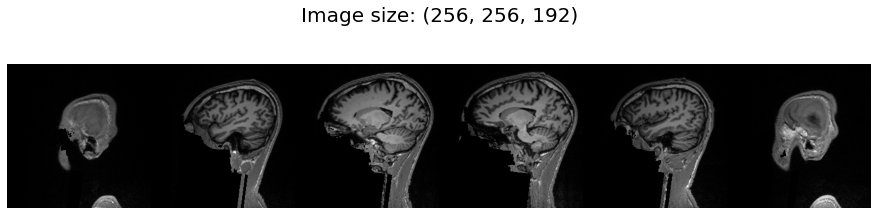

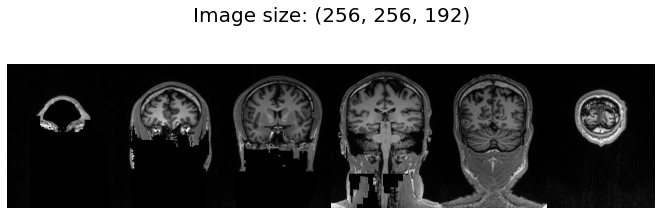

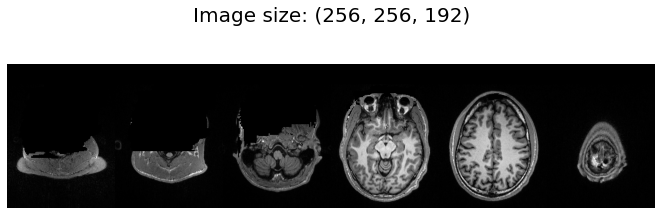

In [5]:
moving = ants.image_read(input_path)
show_slices(moving)

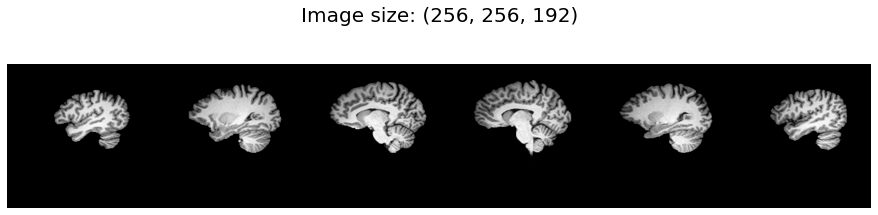

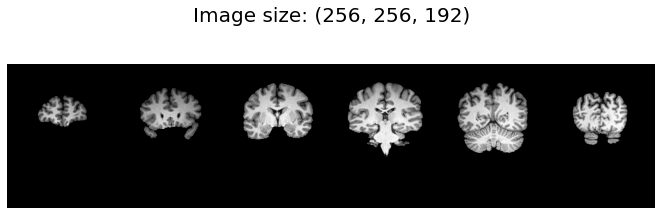

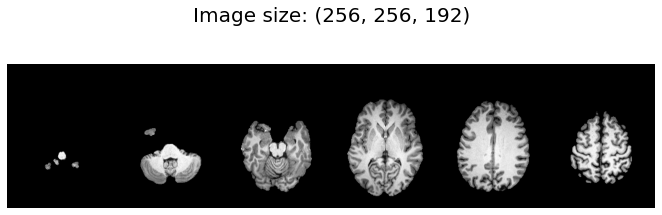

In [17]:
moving_brain = ants.image_read(input_brain_path)
show_slices(moving_brain)

In [27]:
new_brain_mask = deep_brain_skull_stripping(moving.numpy(),output_as_array=False,image_direction=moving.direction,get_mask=True)

Running DeepBrain Skull Stripping...
DeepBrain skull stripping finished.


# Comparing DeepBrain Segmentation against manual Skull Stripping

In [5]:
def calculate_dice_metric(segmented,ground_truth):
    dice = np.sum(segmented[ground_truth==1])*2.0 / (np.sum(segmented) + np.sum(ground_truth))
    print('Dice similarity score is {}'.format(dice))    
    return dice

In [29]:
calculate_dice_metric(new_brain_mask,ants.image_read(input_mask_path).numpy())

Dice similarity score is 0.9745443629076699


0.9745443629076699

In [6]:
dice_metrics = []
input_dir = "/home/lucasthim1/alzheimer_data/NFBS_Dataset/"

In [7]:
def list_images_and_masks(input_dir):
  
    images = list(Path(input_dir).rglob("*T1w.nii.gz"))
    brain_masks = list(Path(input_dir).rglob("*brainmask.nii.gz"))
    return images,brain_masks

In [16]:
def validate_skull_stripping_with_dice_metric(input_path):
    images,brain_masks = list_images_and_masks(input_path)
    dice_metrics = []
    total = len(images)
    for ii,(image_path,brain_mask_path) in enumerate(zip(images,brain_masks)):
        print(f"Processing {ii+1}/{total}...")
        new_brain_mask = deep_brain_skull_stripping(ants.image_read(image_path.as_posix()).numpy(),get_mask=True)
        dice = calculate_dice_metric(new_brain_mask,ants.image_read(brain_mask_path.as_posix()).numpy())    
        dice_metrics.append(dice)
    print('Validation done!')
    dice_metrics = np.array(dice_metrics)
    print('Dice mean of NFBS dataset:',dice_metrics.mean())
    print('Dice std of NFBS dataset:',dice_metrics.std())
    
    return dice_metrics

In [17]:
dice_metrics = validate_skull_stripping_with_dice_metric("/home/lucasthim1/alzheimer_data/NFBS_Dataset/")

Processing 1/125...
Running DeepBrain Skull Stripping...
DeepBrain skull stripping finished.
Dice similarity score is 0.969508336964147
Processing 2/125...
Running DeepBrain Skull Stripping...
DeepBrain skull stripping finished.
Dice similarity score is 0.9720014096421137
Processing 3/125...
Running DeepBrain Skull Stripping...
DeepBrain skull stripping finished.
Dice similarity score is 0.9690028013652477
Processing 4/125...
Running DeepBrain Skull Stripping...
DeepBrain skull stripping finished.
Dice similarity score is 0.9766695299744145
Processing 5/125...
Running DeepBrain Skull Stripping...
DeepBrain skull stripping finished.
Dice similarity score is 0.9707253056164852
Processing 6/125...
Running DeepBrain Skull Stripping...
DeepBrain skull stripping finished.
Dice similarity score is 0.9698555547104789
Processing 7/125...
Running DeepBrain Skull Stripping...
DeepBrain skull stripping finished.
Dice similarity score is 0.9650474918175547
Processing 8/125...
Running DeepBrain Skul

In [18]:
dice_metrics

array([0.96950834, 0.97200141, 0.9690028 , 0.97666953, 0.97072531,
       0.96985555, 0.96504749, 0.96793935, 0.97210002, 0.97358501,
       0.97180856, 0.97189553, 0.97243873, 0.9725169 , 0.93108571,
       0.96964248, 0.97493246, 0.95693706, 0.96850093, 0.96729113,
       0.97379597, 0.97274358, 0.97279044, 0.97163892, 0.97510044,
       0.9713517 , 0.96890486, 0.95987013, 0.97183637, 0.96308247,
       0.97078077, 0.97085928, 0.97533174, 0.97106038, 0.96923094,
       0.97752262, 0.97591542, 0.97387586, 0.96938008, 0.97313021,
       0.96622662, 0.96648945, 0.9682788 , 0.96991429, 0.97447379,
       0.97121595, 0.969514  , 0.97454436, 0.9743316 , 0.97459832,
       0.97135021, 0.96463575, 0.97326186, 0.95986056, 0.97132438,
       0.97659548, 0.97435523, 0.96696729, 0.97368299, 0.97120375,
       0.97380262, 0.96947672, 0.96826569, 0.96909564, 0.97073209,
       0.97191865, 0.97085298, 0.97432083, 0.97007821, 0.97088839,
       0.96569575, 0.97090951, 0.9734652 , 0.97376778, 0.97284

# Testing Skull stripping with S3 method

In [9]:
def apply_s3_skull_stripping(input_path,output_path):
    
    if not os.path.exists(output_path):
        print("Creating output path... \n")
        os.makedirs(output_path)
    images = list_images(input_path)
    dice_metrics = []
    total = len(images)
    print(f"Processing {total} images")
    start = time.time()
    
    for ii,image_path in enumerate(images):
        
        print(f"-------Processing {ii+1}/{total}...--------")
        skull_stripper = SkullStripper(image_path, output_path, want_tissues=False, want_atlas=False)
        output_img_path = skull_stripper.strip_skull()
    
    total_time = (time.time() - start) / 60.
    print('Done with skull stripping! Process took %.2f min) \n' % total_time)
    
def list_images(input_dir):
    images = list(Path(input_dir).rglob("*T1w.nii.gz"))
    return images


def validate_skull_stripping_s3_with_dice_metric(input_path,mask_input_path):
    
    brain_masks = list_masks(input_path)
    true_brain_masks = list_ground_truth_masks(mask_input_path)
    dice_metrics = []
    total = len(true_brain_masks)
    for ii,(brain_mask_path,true_brain_mask_path) in enumerate(zip(brain_masks,true_brain_masks)):
        
        print(f"Processing {ii+1}/{total}...")
        new_brain_mask = ants.image_read(brain_mask_path.as_posix()).numpy()
        new_brain_mask = new_brain_mask > 0
        new_brain_mask[new_brain_mask] = 1
        new_brain_mask[~new_brain_mask] = 0
        
        dice = calculate_dice_metric(new_brain_mask,ants.image_read(true_brain_mask_path.as_posix()).numpy())
        dice_metrics.append(dice)
    print('Validation done!')
    dice_metrics = np.array(dice_metrics)
    print('Dice mean of NFBS dataset:',dice_metrics.mean())
    print('Dice std of NFBS dataset:',dice_metrics.std())
    
    return dice_metrics


def list_ground_truth_masks(input_dir):
    brain_masks = list(Path(input_dir).rglob("*brainmask.nii.gz"))
    return brain_masks

def list_masks(input_dir):
    brain_masks = list(Path(input_dir).rglob("*_mask_refined_reg.nii.gz"))
    return brain_masks

    
def delete_useless_images(input_dir):
    
    available_images = [os.fspath(x) for x in list(Path(input_dir).rglob("*.nii.gz"))]
    if available_images:
        useless_images = [x for x in available_images if "mask_refined_reg" not in x]
        for img in useless_images:
            os.remove(img)

In [7]:
input_dir = "/home/lucasthim1/alzheimer_data/NFBS_Dataset/"
output_dir = '/home/lucasthim1/alzheimer_data/NFBS_Dataset_s3'

In [8]:
set_env_variables()

Setting ANTs and NiftyReg environment variables...



In [83]:
apply_s3_skull_stripping(input_dir,output_dir)

Processing 125 images
-------Processing 1/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00059911/sub-A00059911_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00059911_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00059911_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00059911_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00059911_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 2/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00050940/sub-A00050940_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00050940_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00050940_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00050940_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A0005

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00032875_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00032875_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00032875_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00032875_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 6/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00057444/sub-A00057444_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00057444_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00057444_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00057444_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00057444_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 7/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00037112/sub-A00037112_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00037112_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00037112_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00037112_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A0003

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00054857_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00054857_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00054857_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00054857_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 10/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00061276/sub-A00061276_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00061276_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00061276_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00061276_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A000

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00056627_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00056627_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00056627_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00056627_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 15/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00060006/sub-A00060006_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00060006_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00060006_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00060006_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A000

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00051539_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00051539_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00051539_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00051539_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 30/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00040573/sub-A00040573_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00040573_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00040573_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00040573_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00040573_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 31/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00055542/sub-A00055542_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00055542_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00055542_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00055542_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A000

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00038998_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00038998_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00038998_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00038998_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 37/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00040524/sub-A00040524_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00040524_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00040524_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00040524_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A000

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00040623_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00040623_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00040623_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00040623_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 42/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00057005/sub-A00057005_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00057005_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00057005_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00057005_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A000

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00060848_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00060848_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00060848_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00060848_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 44/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00057372/sub-A00057372_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00057372_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00057372_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00057372_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A000

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00063103_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00063103_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00063103_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00063103_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 48/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00028185/sub-A00028185_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00028185_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00028185_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00028185_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00028185_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 49/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00037848/sub-A00037848_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00037848_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00037848_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00037848_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A000

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00053475_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00053475_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00053475_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00053475_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 51/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00040628/sub-A00040628_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00040628_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00040628_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00040628_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A000

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00035827_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00035827_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00035827_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00035827_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 53/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00056898/sub-A00056898_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00056898_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00056898_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00056898_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A000

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00043721_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00043721_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00043721_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00043721_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 61/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00060632/sub-A00060632_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00060632_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00060632_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00060632_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A000

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00054441_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00054441_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00054441_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00054441_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 65/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00034854/sub-A00034854_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00034854_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00034854_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00034854_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A000

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00052340_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00052340_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00052340_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00052340_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 74/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00057203/sub-A00057203_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00057203_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00057203_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00057203_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A000

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00055121_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00055121_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00055121_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00055121_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 86/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00038642/sub-A00038642_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00038642_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00038642_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00038642_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00038642_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 87/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00058999/sub-A00058999_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00058999_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00058999_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00058999_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00058999_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 88/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00063589/sub-A00063589_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00063589_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00063589_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00063589_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A000

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00055806_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00055806_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00055806_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00055806_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 90/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00043704/sub-A00043704_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00043704_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00043704_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00043704_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A000

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00057786_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00057786_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00057786_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00057786_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 98/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00062282/sub-A00062282_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00062282_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00062282_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00062282_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A000

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00064081_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00064081_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00064081_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00064081_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 100/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00059845/sub-A00059845_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00059845_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00059845_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00059845_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00059845_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 101/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00052125/sub-A00052125_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00052125_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00052125_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00052125_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00056306_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00056306_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00056306_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00056306_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 103/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00063326/sub-A00063326_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00063326_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00063326_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00063326_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00054914_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00054914_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00054914_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00054914_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 105/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00061204/sub-A00061204_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00061204_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00061204_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00061204_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00063368_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00063368_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00063368_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00063368_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 109/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00039431/sub-A00039431_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00039431_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00039431_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00039431_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:92: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:96: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00062248_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00062248_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00062248_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------


/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:147: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:148: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

/home/lucasthim1/mmml-alzheimer-diagnosis/src/utils/skull_stripping_ants/skull.py:149: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To o

Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00062248_ses-NFB3_T1w_masked.nii.gz 

------ Skull Stripping Finished. --------
-------Processing 124/125...--------
Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/NFBS_Dataset/A00058503/sub-A00058503_ses-NFB3_T1w.nii.gz 

Output Folder : /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00058503_ses-NFB3_T1w_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00058503_ses-NFB3_T1w_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00058503_ses-NFB3_T1w_wm.nii.gz

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/sub-A00

In [ ]:
# delete_useless_images(output_dir)

In [14]:
dice_metrics_s3 = validate_skull_stripping_s3_with_dice_metric(output_dir,input_dir)

Processing 1/125...
Dice similarity score is 0.8393879347815734
Processing 2/125...
Dice similarity score is 0.8547984194403482
Processing 3/125...
Dice similarity score is 0.877121334288035
Processing 4/125...
Dice similarity score is 0.871837288699731
Processing 5/125...
Dice similarity score is 0.7888986084104467
Processing 6/125...
Dice similarity score is 0.7391984695635815
Processing 7/125...
Dice similarity score is 0.8464377078620221
Processing 8/125...
Dice similarity score is 0.8084927600419013
Processing 9/125...
Dice similarity score is 0.7842829606024361
Processing 10/125...
Dice similarity score is 0.7933566919423204
Processing 11/125...
Dice similarity score is 0.9244372562481116
Processing 12/125...
Dice similarity score is 0.8776257978019791
Processing 13/125...
Dice similarity score is 0.8189900524796666
Processing 14/125...
Dice similarity score is 0.7899412959167822
Processing 15/125...
Dice similarity score is 0.8221523224092881
Processing 16/125...
Dice similarity

In [15]:
dice_metrics_s3

array([0.83938793, 0.85479842, 0.87712133, 0.87183729, 0.78889861,
       0.73919847, 0.84643771, 0.80849276, 0.78428296, 0.79335669,
       0.92443726, 0.8776258 , 0.81899005, 0.7899413 , 0.82215232,
       0.80913592, 0.88376949, 0.70784357, 0.79692404, 0.85520688,
       0.86727899, 0.8905747 , 0.81478997, 0.90311979, 0.86225198,
       0.80816534, 0.88659698, 0.86857212, 0.87485572, 0.82747465,
       0.8765779 , 0.79964395, 0.81608957, 0.81261536, 0.82247232,
       0.82651882, 0.86684089, 0.75886971, 0.84919091, 0.91004754,
       0.75107872, 0.77580772, 0.87011068, 0.86784813, 0.8632622 ,
       0.84972275, 0.90173895, 0.86979332, 0.9140463 , 0.86169457,
       0.91093097, 0.83279295, 0.800187  , 0.75557756, 0.84665473,
       0.90203702, 0.76067342, 0.78988505, 0.86831294, 0.8945855 ,
       0.83954535, 0.8824589 , 0.80394116, 0.71554562, 0.87234529,
       0.89346524, 0.84709715, 0.85392281, 0.85419555, 0.80522126,
       0.92434252, 0.84608509, 0.87633023, 0.8464832 , 0.80390

# Comparing FSL Skull stripped with Deepbrain skull stripped with Dice Metric

In [14]:
def compare_fsl_with_deepbrain_skull_stripping(input_path,fsl_path):
    images,_ = list_images_and_masks(input_path)
    
    brain_masks = list_masks(fsl_path)
    
    dice_metrics = []
    total = len(images)
    for ii,(image_path,brain_mask_path) in enumerate(zip(images,brain_masks)):
        print(f"Processing {ii+1}/{total}...")
        new_brain_mask = deep_brain_skull_stripping(ants.image_read(image_path.as_posix()).numpy(),get_mask=True)
        dice = calculate_dice_metric(new_brain_mask,ants.image_read(brain_mask_path.as_posix()).numpy())    
        dice_metrics.append(dice)
    print('Validation done!')
    dice_metrics = np.array(dice_metrics)
    print('Dice mean of NFBS dataset:',dice_metrics.mean())
    print('Dice std of NFBS dataset:',dice_metrics.std())
    
    return dice_metrics

    
def list_images(input_dir):
    images = list(Path(input_dir).rglob("*T1w.nii.gz"))
    return images

def list_ground_truth_masks(input_dir):
    brain_masks = list(Path(input_dir).rglob("*brainmask.nii.gz"))
    return brain_masks

def list_masks(input_dir):
    brain_masks = list(Path(input_dir).rglob("*_mask_refined_reg.nii.gz"))
    return brain_masks

    
def delete_useless_images(input_dir):
    
    available_images = [os.fspath(x) for x in list(Path(input_dir).rglob("*.nii.gz"))]
    if available_images:
        useless_images = [x for x in available_images if "mask_refined_reg" not in x]
        for img in useless_images:
            os.remove(img)

In [13]:
output_dir = '/home/lucasthim1/alzheimer_data/NFBS_Dataset_s3/'

In [15]:
dice_metrics_s3_deepbrain = compare_fsl_with_deepbrain_skull_stripping(input_dir,output_dir)

Processing 1/125...

Instructions for updating:
Use tf.gfile.GFile.

Running DeepBrain Skull Stripping...
DeepBrain skull stripping finished.
Dice similarity score is 0.8490469599288964
Processing 2/125...
Running DeepBrain Skull Stripping...
DeepBrain skull stripping finished.
Dice similarity score is 0.8381458532996846
Processing 3/125...
Running DeepBrain Skull Stripping...
DeepBrain skull stripping finished.
Dice similarity score is 0.8933223316065033
Processing 4/125...
Running DeepBrain Skull Stripping...
DeepBrain skull stripping finished.
Dice similarity score is 0.8840136558288424
Processing 5/125...
Running DeepBrain Skull Stripping...
DeepBrain skull stripping finished.
Dice similarity score is 0.8047057422263689
Processing 6/125...
Running DeepBrain Skull Stripping...
DeepBrain skull stripping finished.
Dice similarity score is 0.7427273268242961
Processing 7/125...
Running DeepBrain Skull Stripping...
DeepBrain skull stripping finished.
Dice similarity score is 0.858626735

In [20]:
dice_metrics

array([0.96950834, 0.97200141, 0.9690028 , 0.97666953, 0.97072531,
       0.96985555, 0.96504749, 0.96793935, 0.97210002, 0.97358501,
       0.97180856, 0.97189553, 0.97243873, 0.9725169 , 0.93108571,
       0.96964248, 0.97493246, 0.95693706, 0.96850093, 0.96729113,
       0.97379597, 0.97274358, 0.97279044, 0.97163892, 0.97510044,
       0.9713517 , 0.96890486, 0.95987013, 0.97183637, 0.96308247,
       0.97078077, 0.97085928, 0.97533174, 0.97106038, 0.96923094,
       0.97752262, 0.97591542, 0.97387586, 0.96938008, 0.97313021,
       0.96622662, 0.96648945, 0.9682788 , 0.96991429, 0.97447379,
       0.97121595, 0.969514  , 0.97454436, 0.9743316 , 0.97459832,
       0.97135021, 0.96463575, 0.97326186, 0.95986056, 0.97132438,
       0.97659548, 0.97435523, 0.96696729, 0.97368299, 0.97120375,
       0.97380262, 0.96947672, 0.96826569, 0.96909564, 0.97073209,
       0.97191865, 0.97085298, 0.97432083, 0.97007821, 0.97088839,
       0.96569575, 0.97090951, 0.9734652 , 0.97376778, 0.97284

In [27]:
dice_s3 = np.array([0.83938793, 0.85479842, 0.87712133, 0.87183729, 0.78889861,
       0.73919847, 0.84643771, 0.80849276, 0.78428296, 0.79335669,
       0.92443726, 0.8776258 , 0.81899005, 0.7899413 , 0.82215232,
       0.80913592, 0.88376949, 0.70784357, 0.79692404, 0.85520688,
       0.86727899, 0.8905747 , 0.81478997, 0.90311979, 0.86225198,
       0.80816534, 0.88659698, 0.86857212, 0.87485572, 0.82747465,
       0.8765779 , 0.79964395, 0.81608957, 0.81261536, 0.82247232,
       0.82651882, 0.86684089, 0.75886971, 0.84919091, 0.91004754,
       0.75107872, 0.77580772, 0.87011068, 0.86784813, 0.8632622 ,
       0.84972275, 0.90173895, 0.86979332, 0.9140463 , 0.86169457,
       0.91093097, 0.83279295, 0.800187  , 0.75557756, 0.84665473,
       0.90203702, 0.76067342, 0.78988505, 0.86831294, 0.8945855 ,
       0.83954535, 0.8824589 , 0.80394116, 0.71554562, 0.87234529,
       0.89346524, 0.84709715, 0.85392281, 0.85419555, 0.80522126,
       0.92434252, 0.84608509, 0.87633023, 0.8464832 , 0.80390555,
       0.88783446, 0.80482233, 0.83323166, 0.75340731, 0.86786637,
       0.83313019, 0.88423163, 0.83604529, 0.81021164, 0.83553757,
       0.85520054, 0.85852547, 0.90245391, 0.69516345, 0.78230512,
       0.77978228, 0.8661411 , 0.7807199 , 0.90037913, 0.75436131,
       0.87740501, 0.87522312, 0.8687017 , 0.81147516, 0.94177637,
       0.84609956, 0.82528871, 0.79953805, 0.8832415 , 0.81311507,
       0.8419623 , 0.84776633, 0.82299608, 0.75646409, 0.9013774 ,
       0.8952364 , 0.81600138, 0.88402183, 0.71284084, 0.76323298,
       0.84691637, 0.87489491, 0.77857579, 0.84826887, 0.84093919,
       0.93115857, 0.88435882, 0.828113  , 0.85924064, 0.75128597])

dice_deepbrain = np.array([0.96950834, 0.97200141, 0.9690028 , 0.97666953, 0.97072531,
       0.96985555, 0.96504749, 0.96793935, 0.97210002, 0.97358501,
       0.97180856, 0.97189553, 0.97243873, 0.9725169 , 0.93108571,
       0.96964248, 0.97493246, 0.95693706, 0.96850093, 0.96729113,
       0.97379597, 0.97274358, 0.97279044, 0.97163892, 0.97510044,
       0.9713517 , 0.96890486, 0.95987013, 0.97183637, 0.96308247,
       0.97078077, 0.97085928, 0.97533174, 0.97106038, 0.96923094,
       0.97752262, 0.97591542, 0.97387586, 0.96938008, 0.97313021,
       0.96622662, 0.96648945, 0.9682788 , 0.96991429, 0.97447379,
       0.97121595, 0.969514  , 0.97454436, 0.9743316 , 0.97459832,
       0.97135021, 0.96463575, 0.97326186, 0.95986056, 0.97132438,
       0.97659548, 0.97435523, 0.96696729, 0.97368299, 0.97120375,
       0.97380262, 0.96947672, 0.96826569, 0.96909564, 0.97073209,
       0.97191865, 0.97085298, 0.97432083, 0.97007821, 0.97088839,
       0.96569575, 0.97090951, 0.9734652 , 0.97376778, 0.97284185,
       0.9693135 , 0.96835946, 0.96524547, 0.97092361, 0.97610293,
       0.96920915, 0.97049692, 0.97476876, 0.96865408, 0.96717138,
       0.97207213, 0.96906938, 0.97580666, 0.96856395, 0.97396576,
       0.97066537, 0.9729919 , 0.97417605, 0.97671013, 0.96826863,
       0.96943715, 0.97108888, 0.97489374, 0.96956672, 0.97682108,
       0.96931763, 0.96682566, 0.97430466, 0.96792899, 0.97532305,
       0.97279143, 0.9710792 , 0.96651893, 0.96487031, 0.97145035,
       0.96430573, 0.97722919, 0.96819507, 0.96966307, 0.97475295,
       0.97103638, 0.97672455, 0.97347263, 0.97093751, 0.97224971,
       0.97327004, 0.97422023, 0.97089576, 0.971264  , 0.97761733])

In [29]:
def z_test_two_samples(sample1,sample2):
    n_1 = sample1.shape[0]
    n_2 = sample2.shape[0]
    
    sample1_mean = sample1.mean()
    sample2_mean = sample2.mean()
    
    sigma1 = sample1.std() / np.sqrt(n_1)
    sigma2 = sample2.std() / np.sqrt(n_2)
    
    z = (sample1_mean - sample2_mean) / np.sqrt(sigma1**2 + sigma2**2)
    return z

In [32]:
z_test_two_samples(dice_deepbrain,dice_s3)

29.237660042164283

In [34]:
import seaborn as sns

In [33]:
df_dices = pd.DataFrame({
    'dice_s3': dice_s3,
    'dice_deepbrain':dice_deepbrain
})

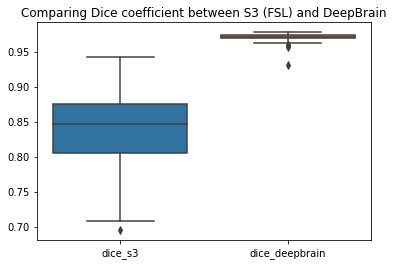

In [43]:
ax = sns.boxplot(data=df_dices)
plt.title('Comparing Dice coefficient between S3 (FSL) and DeepBrain')
plt.show()